<a href="https://colab.research.google.com/github/AnikaL15/ai-song-recommender-system/blob/main/clustering_and_TargetVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import kagglehub
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Download latest version
path = kagglehub.dataset_download("zaheenhamidani/ultimate-spotify-tracks-db")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'ultimate-spotify-tracks-db' dataset.
Path to dataset files: /kaggle/input/ultimate-spotify-tracks-db


In [6]:
path = "/kaggle/input/ultimate-spotify-tracks-db"
os.listdir(path)

['.nfs00000000619de055000004ab', 'SpotifyFeatures.csv']

In [7]:
df = pd.read_csv(path + "/SpotifyFeatures.csv")
df['var_mode'] = df['mode'].map({'Minor': 0, 'Major': 1})
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,var_mode
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814,1
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816,0
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368,0
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227,1
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390,1


In [8]:
feature_cols = [#"var_mode",
                #"duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence"
]


In [9]:
df = df[feature_cols]

In [11]:
df.columns

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence'],
      dtype='object')

In [12]:
X = df[feature_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca_full = PCA(n_components=0.9)
X_pca_full = pca_full.fit_transform(X_scaled)
print(X_scaled.shape[1])
print(X_pca_full.shape[1])


8
5


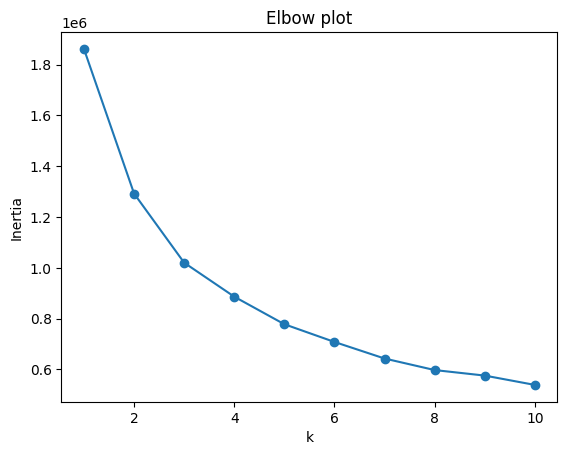

In [13]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_values, inertia, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow plot")
plt.show()

In [14]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")

df["cluster"] = kmeans.fit_predict(X_pca_full)
df.head()


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,cluster
0,0.389,0.910,-1.828,0.0525,0.611,0.000,0.3460,0.814,2
1,0.590,0.737,-5.559,0.0868,0.246,0.000,0.1510,0.816,2
2,0.663,0.131,-13.879,0.0362,0.952,0.000,0.1030,0.368,1
3,0.240,0.326,-12.178,0.0395,0.703,0.000,0.0985,0.227,1
4,0.331,0.225,-21.150,0.0456,0.950,0.123,0.2020,0.390,1


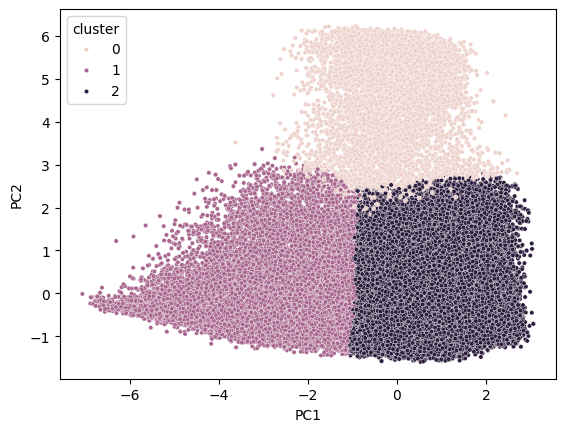

In [15]:
sns.scatterplot(data = df, x=X_pca_full[:,0],y=X_pca_full[:,1],hue= "cluster",s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [16]:

df.groupby("cluster")[feature_cols].mean()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
cluster,,,,,,,,
0,0.562093,0.659147,-11.854813,0.845890,0.771529,0.002377,0.730993,0.418326
1,0.365842,0.212155,-17.508637,0.050687,0.821413,0.442499,0.163943,0.217420
2,0.613092,0.678058,-6.930895,0.096675,0.200690,0.065166,0.198244,0.531846


In [28]:
cluster_ids = kmeans.predict(X_pca_full)
centroids= kmeans.cluster_centers_
target_feature_vector = centroids[cluster_ids]
print(target_feature_vector)

#checking if dimensions match
print(centroids.shape)
print(target_feature_vector.shape)
print(X_pca_full.shape[0],target_feature_vector.shape[0])

[[ 8.96937190e-01 -2.49494285e-01 -3.09934576e-02 -1.06065838e-02
   2.94628025e-04]
 [ 8.96937190e-01 -2.49494285e-01 -3.09934576e-02 -1.06065838e-02
   2.94628025e-04]
 [-2.86294156e+00 -1.77438183e-01  5.36427249e-02 -6.84484343e-03
   1.29336994e-01]
 ...
 [ 8.96937190e-01 -2.49494285e-01 -3.09934576e-02 -1.06065838e-02
   2.94628025e-04]
 [ 8.96937190e-01 -2.49494285e-01 -3.09934576e-02 -1.06065838e-02
   2.94628025e-04]
 [ 8.96937190e-01 -2.49494285e-01 -3.09934576e-02 -1.06065838e-02
   2.94628025e-04]]
(3, 5)
(232725, 5)
232725 232725
